<a href="https://colab.research.google.com/github/pds1920/capstone-group-6/blob/master/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

**Objective of this Project**

The main objective of this project is detecting which species of fish are caught by various fishing boats.

Our goal is to predict the likelihood of fish species in each picture.

The competition on kaggle gives us some information as a starting point.
There are six different categories of fish provided.

![Fish Categories](https://storage.googleapis.com/kaggle-competitions/kaggle/5568/media/species-ref-key.jpg)

Two more categories include:
1. Other (meaning that there are fish in the picture but not in the above categories
2. No Fish (meaning there are no fish in the picture at all)

# **Notebook Setup**



*   Mounting Google Drive
*   Downloading and unzipping dataset
*   Importing neccessary packages




In [0]:
!pip install -q kaggle

In [0]:
# mounting gdrive um daten runterzuladen wenn nötig
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/PDS/'

In [0]:
 # kaggle.json
 from google.colab import files
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"michipds","key":"2924b7242071b81425b660f2b1a5bd87"}'}

In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c the-nature-conservancy-fisheries-monitoring 

  0% 0.00/35.8k [00:00<?, ?B/s]
100% 35.8k/35.8k [00:00<00:00, 29.7MB/s]
  0% 0.00/3.74k [00:00<?, ?B/s]
100% 3.74k/3.74k [00:00<00:00, 3.39MB/s]
 98% 817M/832M [00:09<00:00, 150MB/s]
100% 832M/832M [00:09<00:00, 89.2MB/s]
 99% 1.06G/1.07G [00:13<00:00, 55.1MB/s]
100% 1.07G/1.07G [00:13<00:00, 83.0MB/s]
 99% 229M/231M [00:03<00:00, 70.8MB/s]
100% 231M/231M [00:03<00:00, 69.7MB/s]


In [0]:
pip install scipy==1.1.0


     |████████████████████████████████| 31.2MB 99kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [0]:
from scipy.misc import imread

In [0]:
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from PIL import Image
import glob
import skimage.measure as sm
import pathlib
from matplotlib.image import imread

In [0]:
#unzip train data - new directory train_dir
import zipfile
with zipfile.ZipFile("train.zip", 'r') as zip_ref:
    zip_ref.extractall("train_dir")

In [0]:
#unzip test data - new directory test_dir
import zipfile
with zipfile.ZipFile("test_stg1.zip", 'r') as zip_ref:
    zip_ref.extractall("test_dir")

In [0]:
#unzip test_stg2
!7z x test_stg2.7z


# **Exploratory Data Analysis**

**Objectives** of EDA:
* Visualize properties of dataset
* Some descriptive statistics  
* Getting a feel for the data by exploring
* Support selection of techniques in the training phase of this project





In [0]:
for idx,name in enumerate(os.listdir(path_img)):
    print(idx,name)

0 OTHER
1 NoF
2 LAG
3 ALB
4 BET
5 SHARK
6 YFT
7 DOL
8 .DS_Store


* Eight different categories
* Six describe fish species and two for the outliers (NoF + Other)

In [0]:
ALB = "train_dir/train/ALB"
BET = "train_dir/train/BET"
DOL = "train_dir/train/DOL"
LAG = "train_dir/train/LAG"
NoF= "train_dir/train/NoF"
OTHER = "train_dir/train/OTHER"
SHARK = "train_dir/train/SHARK"
YFT = "train_dir/train/YFT"

In [0]:
path_img = "train_dir/train"

* Set paths for each category

In [0]:
all_count = sum([len(files) for r, d, files in os.walk(path_img)])
all_count

3778



*   3778 images in the training set






## Descriptive Statistics

* Look at the class distribution in training set

In [0]:
ALB_num = sum([len(files) for r, d, files in os.walk(ALB)])
BET_num = sum([len(files) for r, d, files in os.walk(BET)])
DOL_num = sum([len(files) for r, d, files in os.walk(DOL)])
LAG_num = sum([len(files) for r, d, files in os.walk(LAG)])
NoF_num = sum([len(files) for r, d, files in os.walk(NoF)])
OTHER_num = sum([len(files) for r, d, files in os.walk(OTHER)])
SHARK_num = sum([len(files) for r, d, files in os.walk(SHARK)])
YFT_num = sum([len(files) for r, d, files in os.walk(YFT)])
num_list = ALB_num, BET_num, DOL_num, LAG_num, NoF_num, OTHER_num, SHARK_num, YFT_num
num_list

(1719, 200, 117, 67, 465, 299, 176, 734)

* Now that we have the counts for each class, we can build a dataframe and plot accordingly

In [0]:
count_df = pd.DataFrame(num_list, columns=["count"])
count_df.insert(0,"class", ["ALB","BET","DOL","LAG","NoF","OTHER","SHARK","YFT"])
count_df

class  count
0    ALB   1719
1    BET    200
2    DOL    117
3    LAG     67
4    NoF    465
5  OTHER    299
6  SHARK    176
7    YFT    734

In [0]:
count_df = count_df.sort_values("count", ascending=False)
count_df

class  count
0    ALB   1719
7    YFT    734
4    NoF    465
5  OTHER    299
1    BET    200
6  SHARK    176
2    DOL    117
3    LAG     67

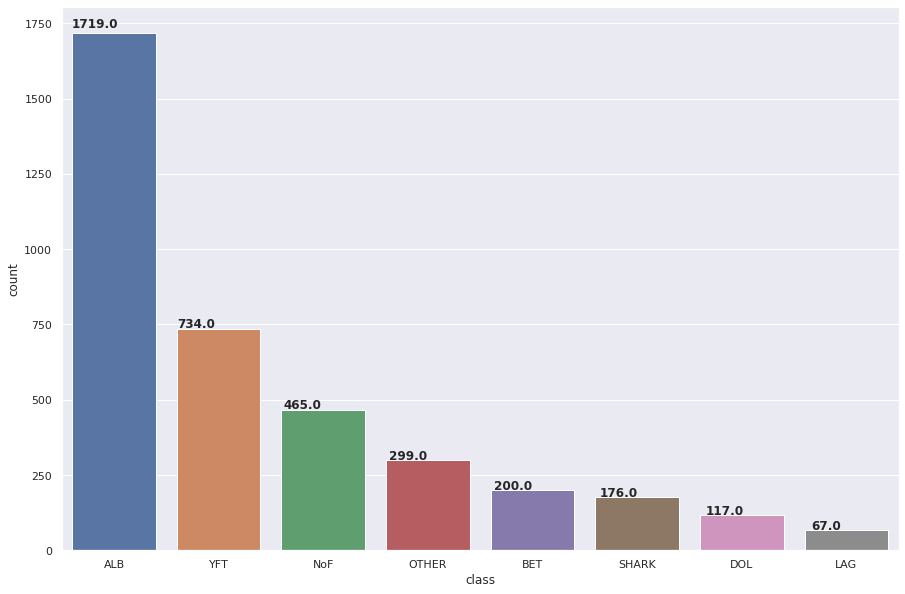

In [0]:
plt.figure(figsize=(15,10))
sns.set(style= "darkgrid")
count_plot = sns.barplot(x="class", y="count", data=count_df)

for p in count_plot.patches:
    count_plot.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.01), weight="bold")

* We can clearly see that the Albacore tuna (**ALB**) is the most common species in the training set with **1719** instances 

Other notable insights:
* **Third** and **fourth** biggest categories are the outliers - "**No** **Fish**" and "**Other**" categories



---

## **Check image sizes**


To determine a starting point for building a well-performing model it is necessary to look at the natural resolution of the provided training-pictures

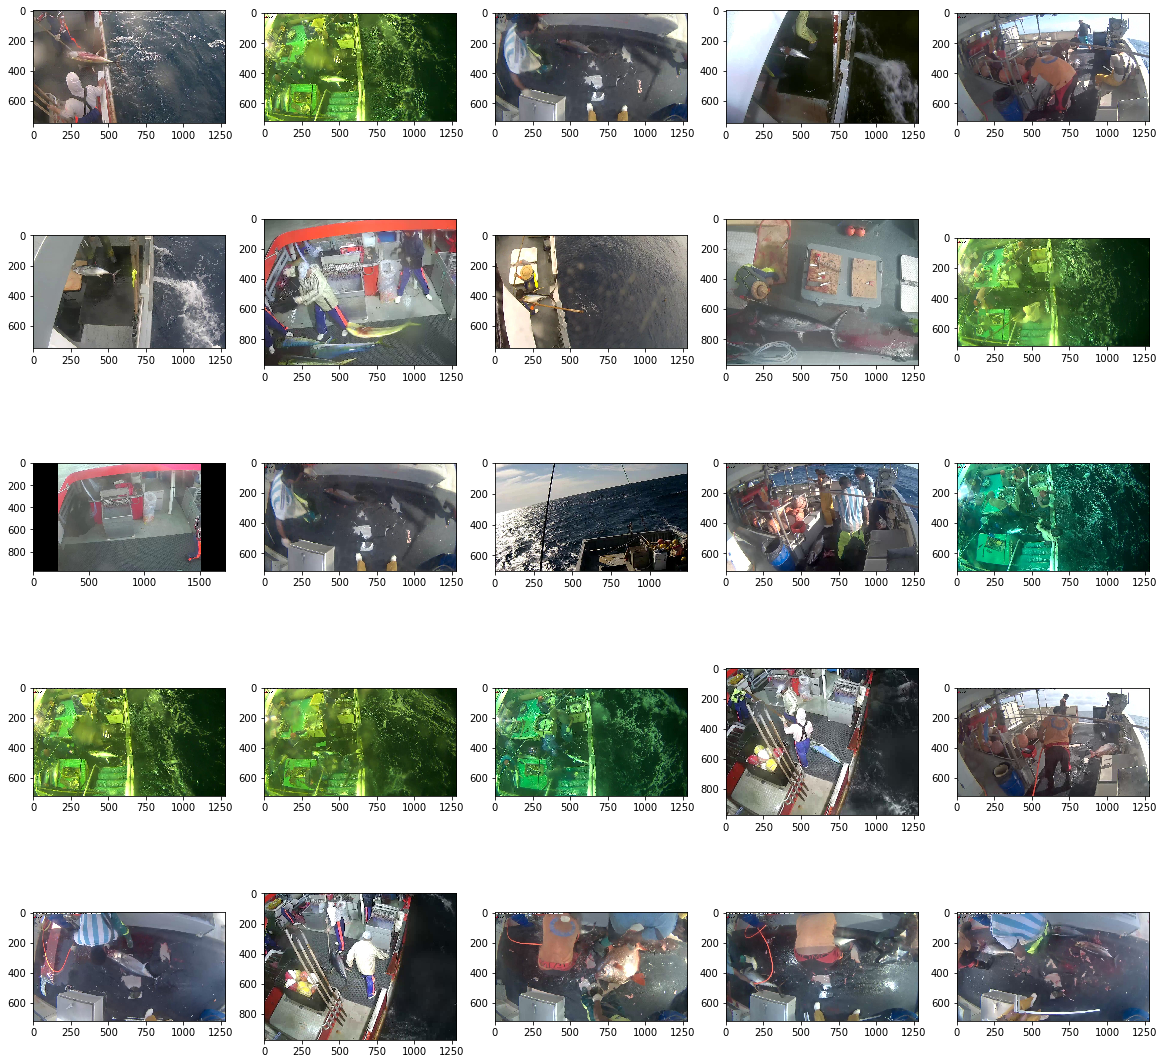

In [0]:
sample_images = list(pathlib.Path("/content/train_dir/train").rglob('*/*/'))
np.random.seed(42)
rand_imgs = np.random.choice(sample_images, size=5*5)
fig, axarr = plt.subplots(5, 5, figsize=(20, 20))

for i, rand_img in enumerate(rand_imgs):
    j = i // 5
    k = i % 5
    axarr[j][k].imshow(imread(rand_img))
    axarr[j][k].grid(False)

We can see that the images of our dataset are in different resolutions.

Seems to be mostly: **1280x7XX (720-750**) and **1280x9XX (924-974)**
 
 [Code](https://github.com/ResidentMario/progressive-resizing/blob/master/notebooks/data-and-model-evaluation.ipynb) Credit(for the display of rnd images with resolution as axis)



---



Lets now look at the **Image sizes** in the trainset more closely

In [0]:
import glob

In [0]:
train_files = sorted(glob.glob('/content/train_dir/train/*/*.jpg'), key=lambda x: random.random())
train = np.array([imread(img) for img in train_files])
print('Length of train {}'.format(len(train)))

Length of train 3777


Credit "Anokas" for the [code](https://www.kaggle.com/anokas/finding-boatids) above 

In [0]:
shapes = np.array([str(img.shape) for img in train])
count_series = pd.Series(shapes).value_counts()
count_series

(720, 1280, 3)    2174
(750, 1280, 3)     598
(974, 1280, 3)     395
(718, 1276, 3)     220
(670, 1192, 3)     198
(924, 1280, 3)      60
(854, 1518, 3)      39
(974, 1732, 3)      35
(750, 1334, 3)      31
(700, 1244, 3)      27
dtype: int64

In [0]:
size_df = pd.DataFrame(count_series, columns= ["Count"])
size_df.index.names = ["Resolution"]
size_df

Count
Resolution           
(720, 1280, 3)   2174
(750, 1280, 3)    598
(974, 1280, 3)    395
(718, 1276, 3)    220
(670, 1192, 3)    198
(924, 1280, 3)     60
(854, 1518, 3)     39
(974, 1732, 3)     35
(750, 1334, 3)     31
(700, 1244, 3)     27

In [0]:
size_df = size_df.reset_index()

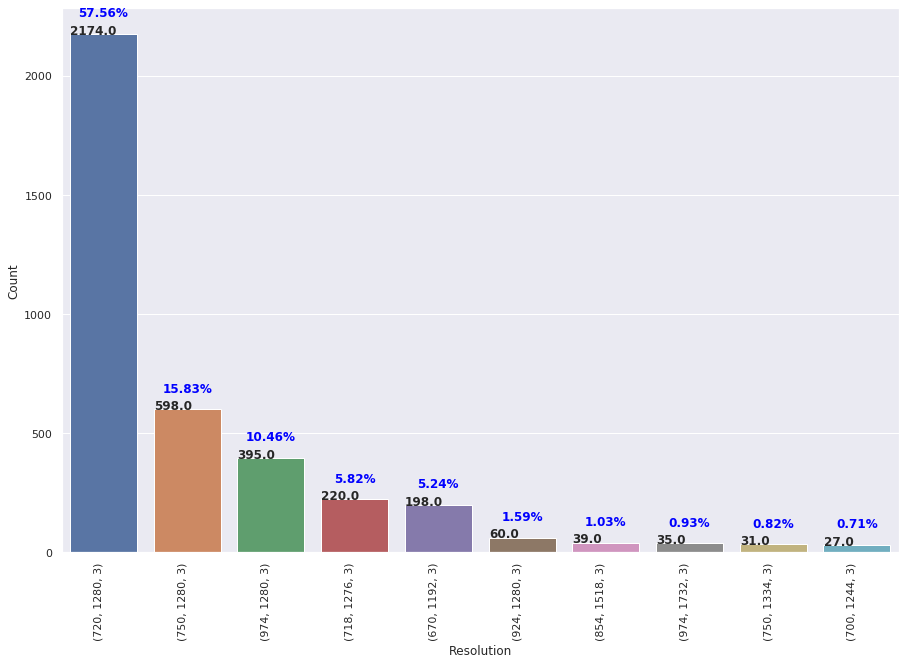

In [0]:
plt.figure(figsize=(15,10))
sns.set(style= "darkgrid")
train_plot = sns.barplot(x="Resolution", y="Count", data=size_df)
train_plot.set_xticklabels(train_plot.get_xticklabels(), rotation=90, horizontalalignment="right")
for p in train_plot.patches:
    train_plot.annotate(str(p.get_height()), (p.get_x() * 1.001, p.get_height() * 1.001), ha= "left", weight = "bold")
total = 3777
for p in train_plot.patches:
         height = p.get_height()
         train_plot.text(p.get_x()+p.get_width()/2.,
            height +75,
            '{:1.2f}%'.format(100 * height/total),
            ha="center", color = "blue", weight="semibold") 

Most pictures are in a **1280x720** (2174 of 3777) or **1280x750** (598) resolution which is quite large for training and could lead to long training epochs

Batchsize would have to be low, to get a respectable training time

Other pictures are in similar resoultion 



---


Lets now have a look at the test dataset (stage 1), in respect to the resolutions of those images

Hopefully the distribution will be similar to the trainset

In [0]:
test_files = sorted(glob.glob('/content/test_dir/test_stg1/*.jpg'), key=lambda x: random.random())
test = np.array([imread(img) for img in test_files])
print('Length of test {}'.format(len(test)))

Length of test 1000


In [0]:
shapes_test = np.array([str(img.shape) for img in test])
test_count = pd.Series(shapes_test).value_counts()
size_test_df = pd.DataFrame(test_count, columns= ["Count"])
size_test_df.index.names = ["Resolution"]
size_test_df = size_test_df.reset_index()
size_test_df

Resolution  Count
0  (720, 1280, 3)    606
1  (750, 1280, 3)    148
2  (974, 1280, 3)     98
3  (718, 1276, 3)     57
4  (670, 1192, 3)     45
5  (854, 1518, 3)     21
6  (750, 1334, 3)     11
7  (924, 1280, 3)      7
8  (700, 1244, 3)      4
9  (974, 1732, 3)      3

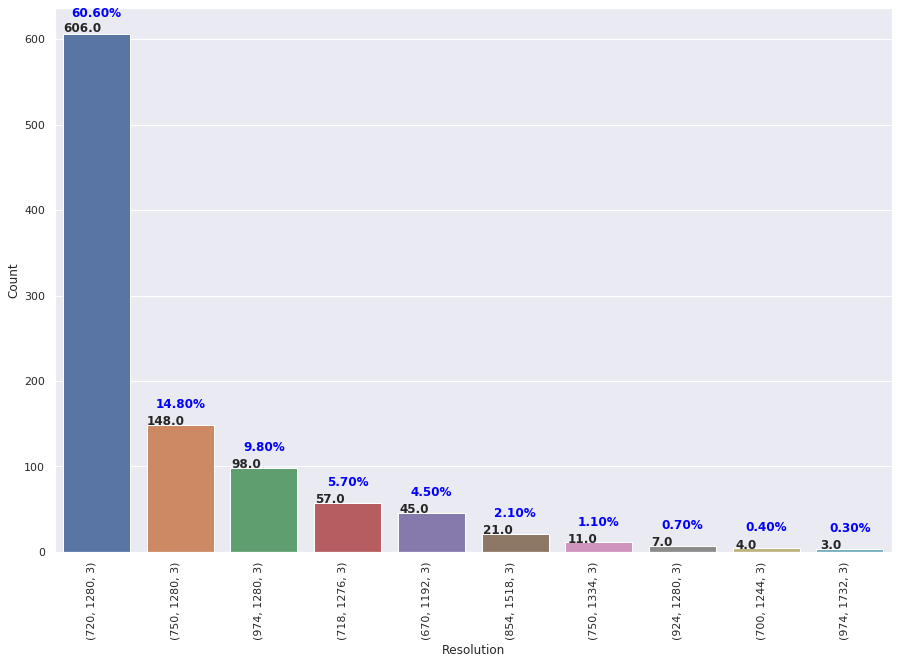

In [0]:
plt.figure(figsize=(15,10))
sns.set(style= "darkgrid")
test_plot = sns.barplot(x="Resolution", y="Count", data=size_test_df)
test_plot.set_xticklabels(test_plot.get_xticklabels(), rotation=90, horizontalalignment="right")
for p in test_plot.patches:
    test_plot.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), weight="bold")
    total = 1000
for p in test_plot.patches:
         height = p.get_height()
         test_plot.text(p.get_x()+p.get_width()/2.,
            height +20,
            '{:1.2f}%'.format(100 * height/total),
            ha="center", color = "blue", weight="semibold") 

We can see that the distribution of natural resolutions in the testset is similar to the trainset
(percentages in blue)



---
---
---
# **Training the Model**

In our training approaches we will use the **progressive resizing method** proposed by Jeremy Howard.

This was the first training approach for our classifier. More advanced training approaches are located in the training notebooks and will be explained in the last two chapters.

**Progressive resizing approach**
- **start small, because:**
"Since small-image models generalize well to larger input sizes, and since they take less time to train, and since the first batch of models we build are going to be highly experimental anyway, why don’t we save time and just train our first few models on small data, and worry about scaling up the images and the models later"
* **Further explanation:** 
"The practical result is that while a model trained on very small images will learn fewer features than one trained on very large images, the ones that it does learn will be the most important ones. Thus a model architecture that works on small images will generalize to larger ones."
[Source](https://towardsdatascience.com/boost-your-cnn-image-classifier-performance-with-progressive-resizing-in-keras-a7d96da06e20) 

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path_img, train=".",
                                  ds_tfms=get_transforms(),
                                  valid_pct=0.2,
                                  size=224,
                                  bs=32,
                                  ).normalize(imagenet_stats)

In [0]:
data.classes

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

* Take a look at our newly created databunch (which is the starting point for training in fastai)

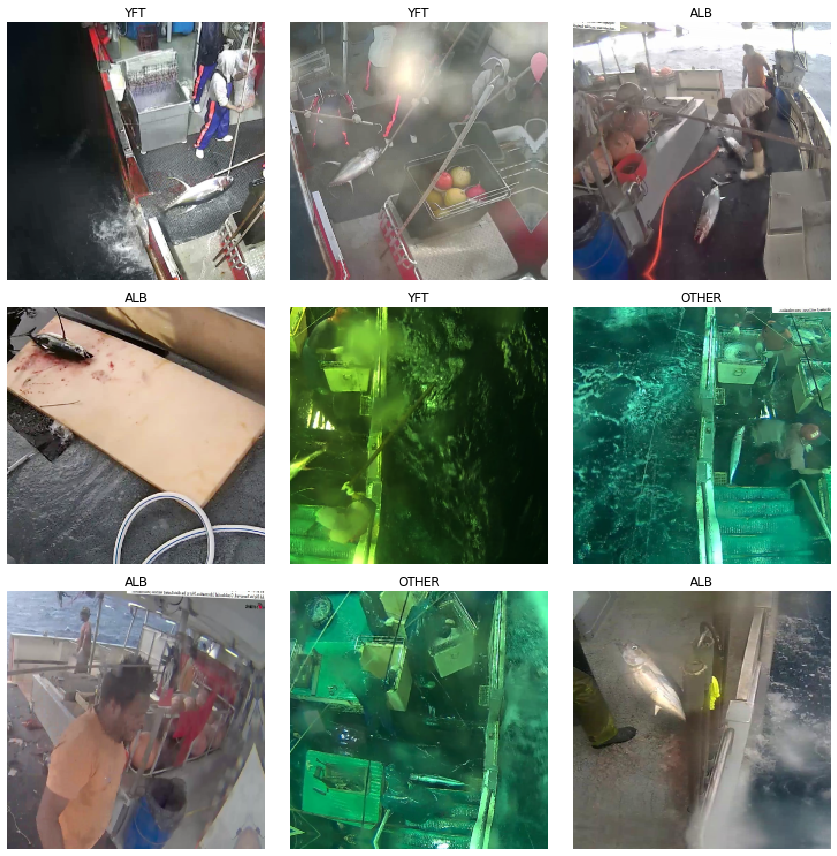

In [0]:
data.show_batch(3)

* Also take a look at the validation set

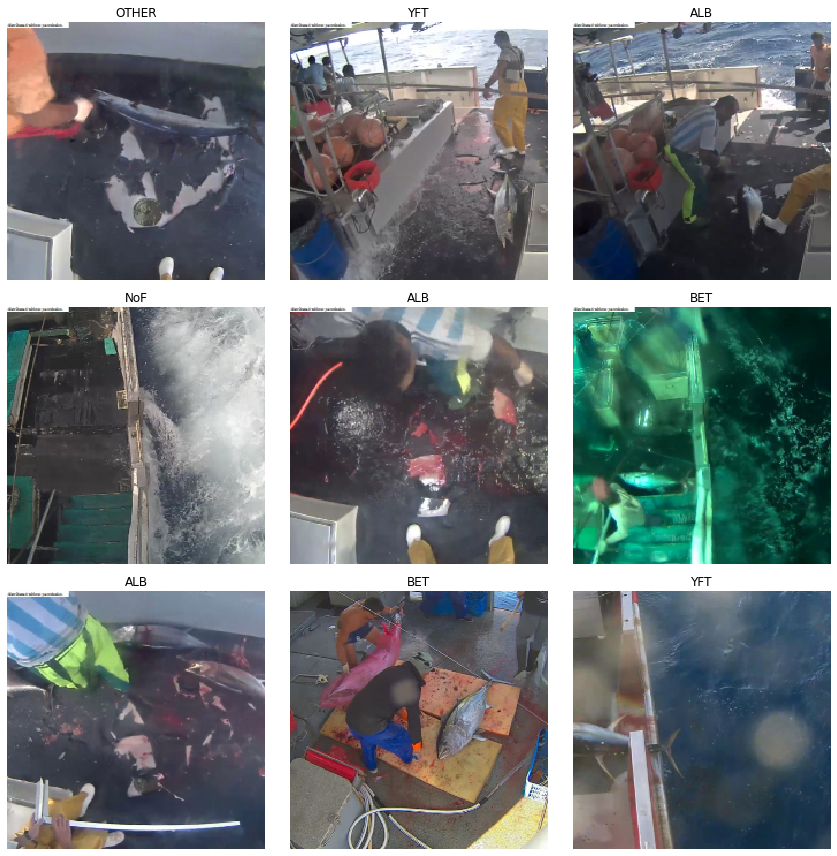

In [0]:
data.show_batch(3, ds_type=DatasetType.Valid)

* Create a learner - CNN **architecture** will be "**resnet34**" because of the good performance/low number of operations needed

**Comparison of CNN-Architectures**


![Comp](https://www.researchgate.net/profile/Frank_Koss/publication/320084139/figure/fig2/AS:543716588744704@1506643544031/Comparison-of-popular-CNN-architectures-The-vertical-axis-shows-top-1-accuracy-on.png)


* After a first round of training with frozen layers (only training the last layer of the resnet), we will unfreeze the model to train and adapt weights throughout the net

In [0]:
learn = cnn_learner(data, models.resnet34, metrics= accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 59.1MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


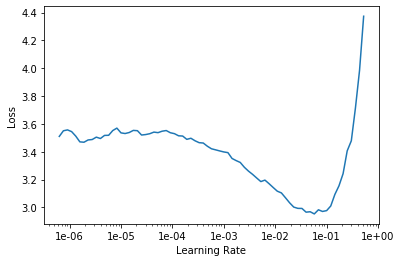

In [0]:
learn.lr_find()
learn.recorder.plot()

We try to find a suitable learning rate for our model since the learning rate is the most important hyper-parameter to tune for training deep neural networks.

We choose a learning rate based on the LR Finder Plot (Point with the steepest slope, method used in fastai is called cyclical learning rates; see [here](https://arxiv.org/abs/1506.01186) )

In [0]:
learn.fit_one_cycle(5, max_lr=1.0e-3)

In [0]:
learn.save("stage-1")

In [0]:
learn.unfreeze()

Now we are not only training the last layers of the CNN but the whole network

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


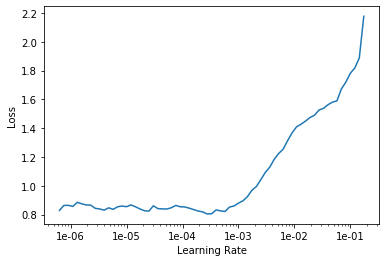

In [0]:
learn.lr_find()
learn.recorder.plot()

Rule of thumb for training an unfrozen network is to pass a max learning rate parameter, pass it a slice and make the second part of that slice 1/10 the size of your first stage

In [0]:
learn.fit_one_cycle(6, slice(1e-5, 1e-3))

In [0]:
learn.save("stage-2")

In [0]:
learn.export("fish")

* After saving and exporting the trained model, we can now start the **resizing** process

* Start by moving up in size to 352x352

In [0]:
#change size
data = ImageDataBunch.from_folder(path_img, train=".",
                                  ds_tfms=get_transforms(),
                                  valid_pct=0.2,
                                  size=352,
                                  bs=32,
                                  ).normalize(imagenet_stats)
learn.data= data

In [0]:
learn.freeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Have to refreeze the learner before continuing the training process

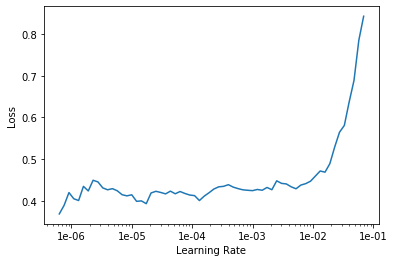

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-5)

In [0]:
learn.save("stage1-352")

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


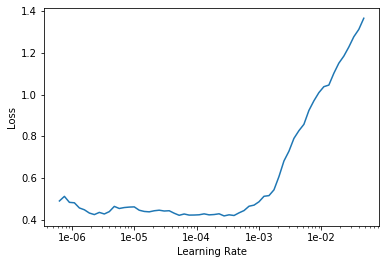

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(6, slice(1e-6, 1e-4))

In [0]:
learn.save("stage2-352")

In [0]:
learn.export("fish2")

Further resizing to 480x480

In [0]:
#change size
data = ImageDataBunch.from_folder(path_img, train=".",
                                  ds_tfms=get_transforms(),
                                  valid_pct=0.2,
                                  size=480,
                                  bs=32,
                                  ).normalize(imagenet_stats)
#learn.data= data

In [0]:
learn.freeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


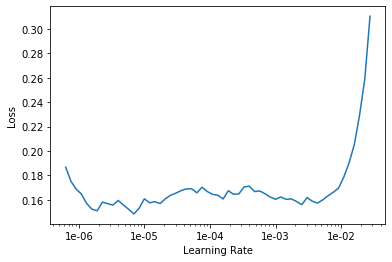

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-5)

In [0]:
learn.save("stage1-480-resize")

In [0]:
learn = cnn_learner(data, models.resnet34, metrics= accuracy).load("stage1-480-resize")

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


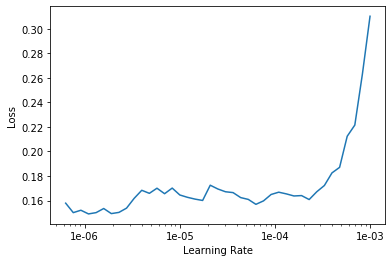

In [0]:
learn.lr_find()
learn.recorder.plot()


In [0]:
learn.fit_one_cycle(6, slice(1e-6, 1e-4))

In [0]:
learn.save("stage2-480-resize")

In [0]:
learn.export("fish-480")

In [0]:
data = ImageDataBunch.from_folder(path_img, train=".",
                                  ds_tfms=get_transforms(),
                                  valid_pct=0.2,
                                  size=480,
                                  bs=32,
                                  ).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics= accuracy).load("/content/gdrive/My Drive/stage2-480-resize")

In [0]:
#import the learner
learn = load_learner("/content/gdrive/My Drive")

## Model Evaluation and Interpretation

* Lets have a look at our top losses (with the Grad-CAM Method)
* We will also look at the Confusion Matrix to identify certain classes, which are troublesome for our model

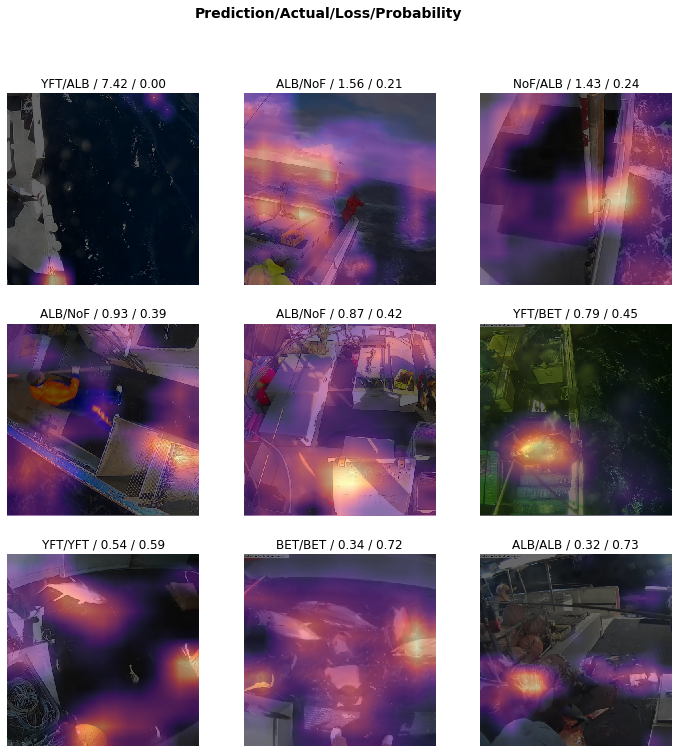

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, heatmap=True)

* Model seems to have some problems with pictures that include **multiple fish**(the two pictures in the bottom row - predictions were correct but not with high probality).
 Using an object detection or instance segmentation approach would help with this kind of problem (more on this later)
* Pictures with a lot of **noise (e.g. water, fishing equipment, the boat itself)** are harder to classify

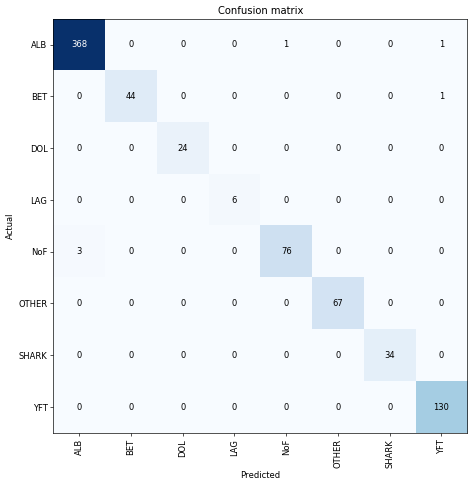

In [0]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [0]:
interp.most_confused(min_val=1)

[('NoF', 'ALB', 3), ('ALB', 'NoF', 1), ('ALB', 'YFT', 1), ('BET', 'YFT', 1)]

* Only a few misclassifications.
* Minor problems with ALB/NoF classes (3 NoF were predicted as ALB)

## Make Predictions and Submit

Creating a dataframe with the predictions for each picture and converting it into a csv file for submission

In [0]:
#add test set to learner (stg1)
learn.data.add_test(ImageList.from_folder("/content/test_dir/test_stg1"))

In [0]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
names_stg1 = [x.name for x in learn.data.test_ds.items]

In [0]:
res_stg1 = pd.DataFrame(preds.numpy(), columns=learn.data.classes)

In [0]:
res_stg1.insert(0, 'image', names_stg1)

In [0]:
res_stg1.head()

image           ALB       BET  ...         OTHER     SHARK           YFT
0  img_01716.jpg  3.307031e-08  0.000263  ...  4.835895e-06  0.000003  2.629336e-06
1  img_07050.jpg  1.831337e-01  0.033338  ...  1.203736e-02  0.032561  1.253577e-02
2  img_06756.jpg  9.727449e-01  0.001341  ...  2.195925e-02  0.000114  2.750183e-03
3  img_02077.jpg  3.820297e-01  0.020785  ...  3.852494e-01  0.001327  1.152207e-02
4  img_06914.jpg  3.213437e-06  0.000012  ...  9.870712e-07  0.000002  4.943013e-07

[5 rows x 9 columns]

In [0]:
#stage 2
learn.data.add_test(ImageList.from_folder("/content/test_stg2"))

In [0]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)


In [0]:
#prefix for image names
names_stg2 = ['test_stg2/'+x.name for x in learn.data.test_ds.items]

In [0]:
res_stg2 = pd.DataFrame(preds.numpy(), columns=learn.data.classes)

In [0]:
res_stg2.insert(0, 'image', names_stg2)

In [0]:
#combine stg1 + stg2
pd.concat([res_stg1, res_stg2]).to_csv('submission1.csv', index=False)

First Submission on kaggle [(csv)](https://github.com/pds1920/capstone-group-6/blob/master/csv_files/submission1.csv)

![alt text](https://i.imgur.com/bFGqS8Q.png)

## Discussing other Training Methods

Since we did not want to overcrowd this notebook with different training methods, you can find our different approaches in the training folder on github  [(Training)](https://github.com/pds1920/capstone-group-6/tree/master/Training).

In the following part we will explain the thoughts that went into the different approaches. We will also provide the Kaggle Scores for the different methods

**Methods** and **approaches** used:

1. Using a different **CNN architecture**, specifically **ResNet50**

  * This did not have a drastic impact on the performance of the learner - time 
spent training was also similar. We used ResNet50 for all of the following approaches.


2. Training the model on the **natural resolution** of the pictures in the training set (**1280x720**, as found in the EDA) [(Link)](https://colab.research.google.com/github/pds1920/capstone-group-6/blob/master/TrainingWithResnet50andDiffSizes.ipynb)

  * After training the model for one cycle on a small resolution (224) we increased the size to the natural resolution. This improved the performance but increased the time spent training enormously (even with batchsize=8). 
  * After increasing the size a second time we were not able to get predictions and submit because of the RAM limitations of google colab (even with increased ram of 25GB - [kaggle-csv](https://github.com/pds1920/capstone-group-6/blob/master/csv_files/submissionresnet50resize.csv))
  ![alt text](https://i.imgur.com/UgysD6y.png)


3. Training with even **smaller resolutions** than in this notebook - 64; 128. [(Link)](https://colab.research.google.com/github/pds1920/capstone-group-6/blob/master/Small_retrain_mixup_customtransforms.ipynb)

  * Using many epochs and small resolutions lead to an improvement in time-spent training, but decreased performance of the learner enormously. [(kaggle-csv)](https://github.com/pds1920/capstone-group-6/blob/master/csv_files/submissionsmallretrain.csv) 

    ![alt text](https://i.imgur.com/oBjhzSS.png)



4. Using **mixup** [(Link)](https://colab.research.google.com/github/pds1920/capstone-group-6/blob/master/Small_retrain_mixup_customtransforms.ipynb)

  * Mixup is a data augmentation trick. In mixup, instead of feeding the network raw images, two images are taken and transformed into a linear combination of both. This helps with generating "additional" training data. Sizes used were 224 and 480 for one cycle each. This approach was combined with custom transforms.


5. Trying out **custom transforms**

  * After having a look at the training dataset, we noticed that a lot of pictures were taken in the dark. Another interesting insight was that the fish are often very tiny because of the distance to the camera or the angle. 
  * To combat these two inconveniences we changed some of the fastai transform parameters
  *  Standard transforms are : 
  
    `(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75) `
  * We increased the max_zoom to 1.6, max_lighting to 0.8, max_warp to 0.4, p_affine to 0.8 and p_lighting to 1 (p_lighting and affine are just probabilities for the transform of warp and lighting to be applied)
  * This lead to the best Kaggle score for a single model (not using ensemble methods - [kaggle-csv](https://github.com/pds1920/capstone-group-6/blob/master/csv_files/submissionsmixup_customtransforms.csv))
  ![alt text](https://i.imgur.com/UptHB6f.png)


6. Using **ensemble learning** [(Link)](https://colab.research.google.com/github/pds1920/capstone-group-6/blob/master/Training/Ensemble.ipynb)

  * We used a blending approach to improve the performance of our models. At this point we had about six different models with different configurations. 
  
  * There is a possibility that some of these models were excellent at recognizing the different tuna species while another model was better at distinguishing between fish or no fish. Because of this we wanted to let the models work together to find a solution that is better than any single model prediction.
  * Blending is a very simple procedure where all predictions are added to each other for each image, class pair and then divided by the number of models.
([Source](https://www.kaggle.com/sbrugman/tricks-for-the-kaggle-leaderboard) for this approach -  [kaggle-csv](https://github.com/pds1920/capstone-group-6/blob/master/csv_files/ensemble3.csv))
![alt text](https://i.imgur.com/RksRWSP.png)



# **Insights**
In this final part of the classification notebook we will report on some of the insights we made during the course of the project. We will also report some of the ideas for further improvement of the classifier (most were not implemented because of lack of python knowledge)

1. **Callbacks**
  * After training numerous models and playing around with the epochs, we found a great way to optimize this using "Callbacks". SaveModelCallback can be used to save the model at every epoch, or in our case the best model for a given metric.

    Example: 
`callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name="mixup_s1")])`

  * This method will save the model at every epoch that improves the accuracy under the name "mixup_s1". This method saved a lot of time playing around with the epochs and retraining to optimize the performance of the model.

2. **Benefit of doing a thorough Exploratory Data Analysis**
  * Looking at the dataset more closely helped us develop ideas for different training approaches
  * One of these ideas was the training on natural resolution of the pictures which unfortunately did not have the desired results
  * Another idea, that absolutely improved the performance, was the customizing of the fastai transforms. We saw that there were pictures with natural daylight as well as pictures that were taken at night (which would benefit from more lighting)
  * Same principle applies to increasing the max_zoom in the transforms. The fish often only take up a very tiny part of the image.

  Example:
  ![alt text](https://i.imgur.com/0SgnwJ3.jpg)

  * Another idea for this problem could be to split the training set further into pictures at **day / night** and train models for each. Combine these models using a ensemble approach and hope for better generalization of the model.
  This split could be achieved by looking at the RGB components of the images, since all the night images have a greenish look (see above). Applying a k-means algorithm could then cluster all the images with a high green-component. 

  * Moreover we discovered that the training set contains a lot of "near duplicates", meaning pictures that were taken seconds after each other. Removing these near duplicates would maybe help the model generalize better. (Could potentially be achieved via kNN-method)

  * The EDA also revealed some problems with the quality of the dataset. When having a thorough look at the different datasets (train/teststg1/teststg2) we found many images which are not appropriate for classification/segmentation.
  These images probably should have been removed prior to training because they distort the model in the training phase or skew the performance while testing. This is why data preparation can be the most important part of a deep learning project.

  Example: ![alt text](https://i.imgur.com/8ULjRe2.jpg)

3. **Google Drive**
  * After some time we used Google Drive to save our models and the different datasets. This lead to a much smoother workflow and decreased setup times. 

# **Further Approach and Outlook**

We managed to train a classifier for this project that performed pretty well (Rank 26 Kaggle Private Leaderboard). Using all the different methods we learned in the lecture and some ensemble methods proved to be sufficient for the task at hand. 
Unfortunately this simple classifier approach has its limitations. For example:


*   Images with **multiple fish** of different species. A regular classifier will have a hard time predicting these kind of scenarios.

*  There is no **localization** of the fish in the image. Benefit of a localization would be a more meaningful and easier to analyze image for the end user.

* Using the Grad-CAM method we can identify some of the overfitting tendencies that are adapted during the learning period. Having certain background information for a specific species of fish could lead to the learner not classifying because it learned to identify the fish but rather predict based on the background information. Example for this during our training (face of the fisherman was used to predict):

![alt text](https://i.imgur.com/TIMeNLS.png)


* A  regular classifier would be more appropriate if the fish would take up most of the space in the used images. Unfortunately the images are often taken from far away or from a specific angle which makes the fish appear very small. This leads to an image that has 95% or more useless information for our classifier. 

Fortunately the [**object detection approach**](https://github.com/pds1920/capstone-group-6/blob/master/ObjectDetectionRetina.ipynb) that will be used in the second part of our project can overcome most of these problems.

